### Reference: https://www.kaggle.com/code/rcushen/topic-modelling-with-lsa-and-lda/notebook
# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [13]:
datafile = '/Users/tracyhanwenyu/Desktop/abcnews-date-text.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

raw_data.head()
raw_data.info() 

/var/folders/15/8x1xyv894n376lc7h61_d8p00000gn/T/ipykernel_39188/2903980410.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244184 entries, 0 to 1244183
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   publish_date   1244184 non-null  datetime64[ns]
 1   headline_text  1244184 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 19.0+ MB


In [14]:
deduplicated_data = raw_data.astype({'headline_text': str}).drop_duplicates(subset='headline_text', keep='first')

print("Data volume after deduplication:", len(deduplicated_data))

Data volume after deduplication: 1213004


In [21]:
reindexed_data = deduplicated_data.head(50000)['headline_text']
reindexed_data.index = deduplicated_data.head(50000)['publish_date']
reindexed_data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 50000 entries, 2003-02-19 to 2003-10-21
Series name: headline_text
Non-Null Count  Dtype 
--------------  ----- 
50000 non-null  object
dtypes: object(1)
memory usage: 781.2+ KB


In [22]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

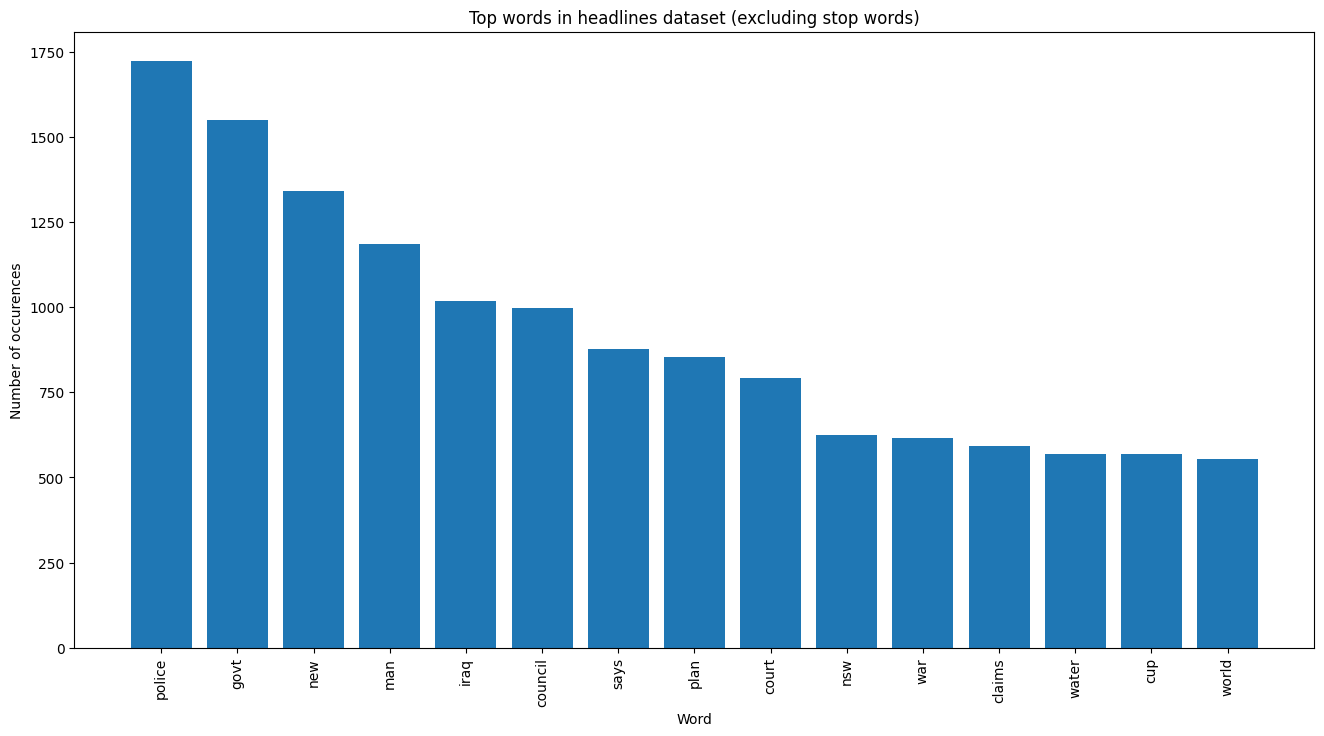

In [23]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [24]:
tagged_headlines = [TextBlob(reindexed_data.iloc[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [25]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  318210
Mean number of words per headline:  6.3642


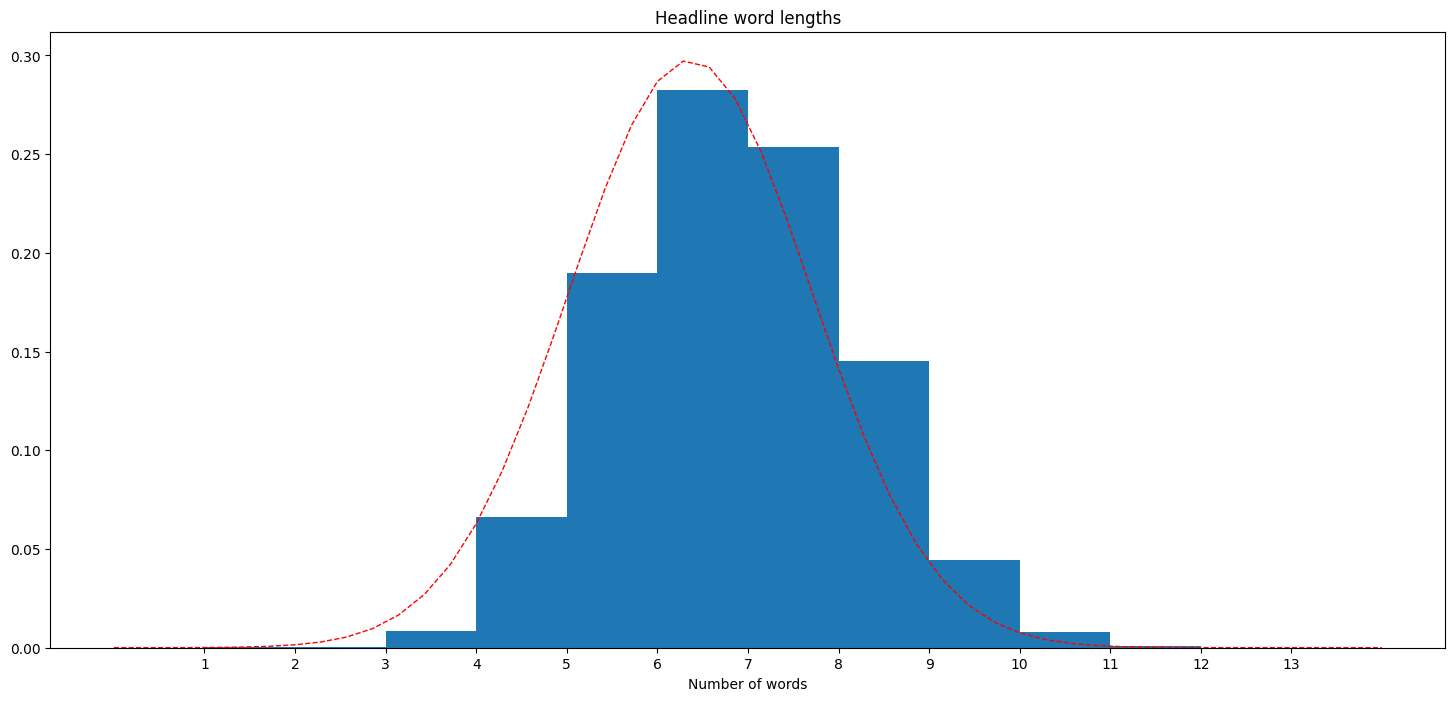

In [26]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

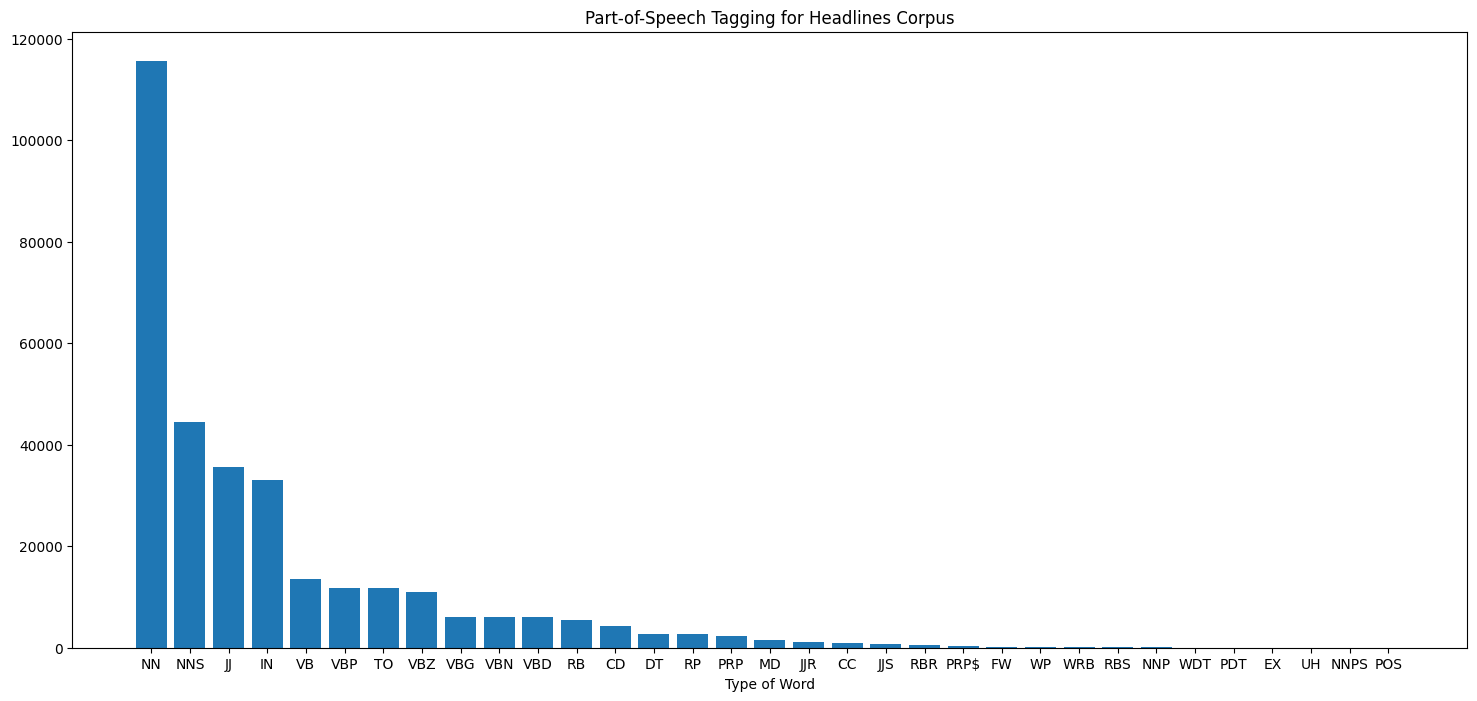

In [27]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

/var/folders/15/8x1xyv894n376lc7h61_d8p00000gn/T/ipykernel_39188/2472981263.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = reindexed_data.resample('M').count()


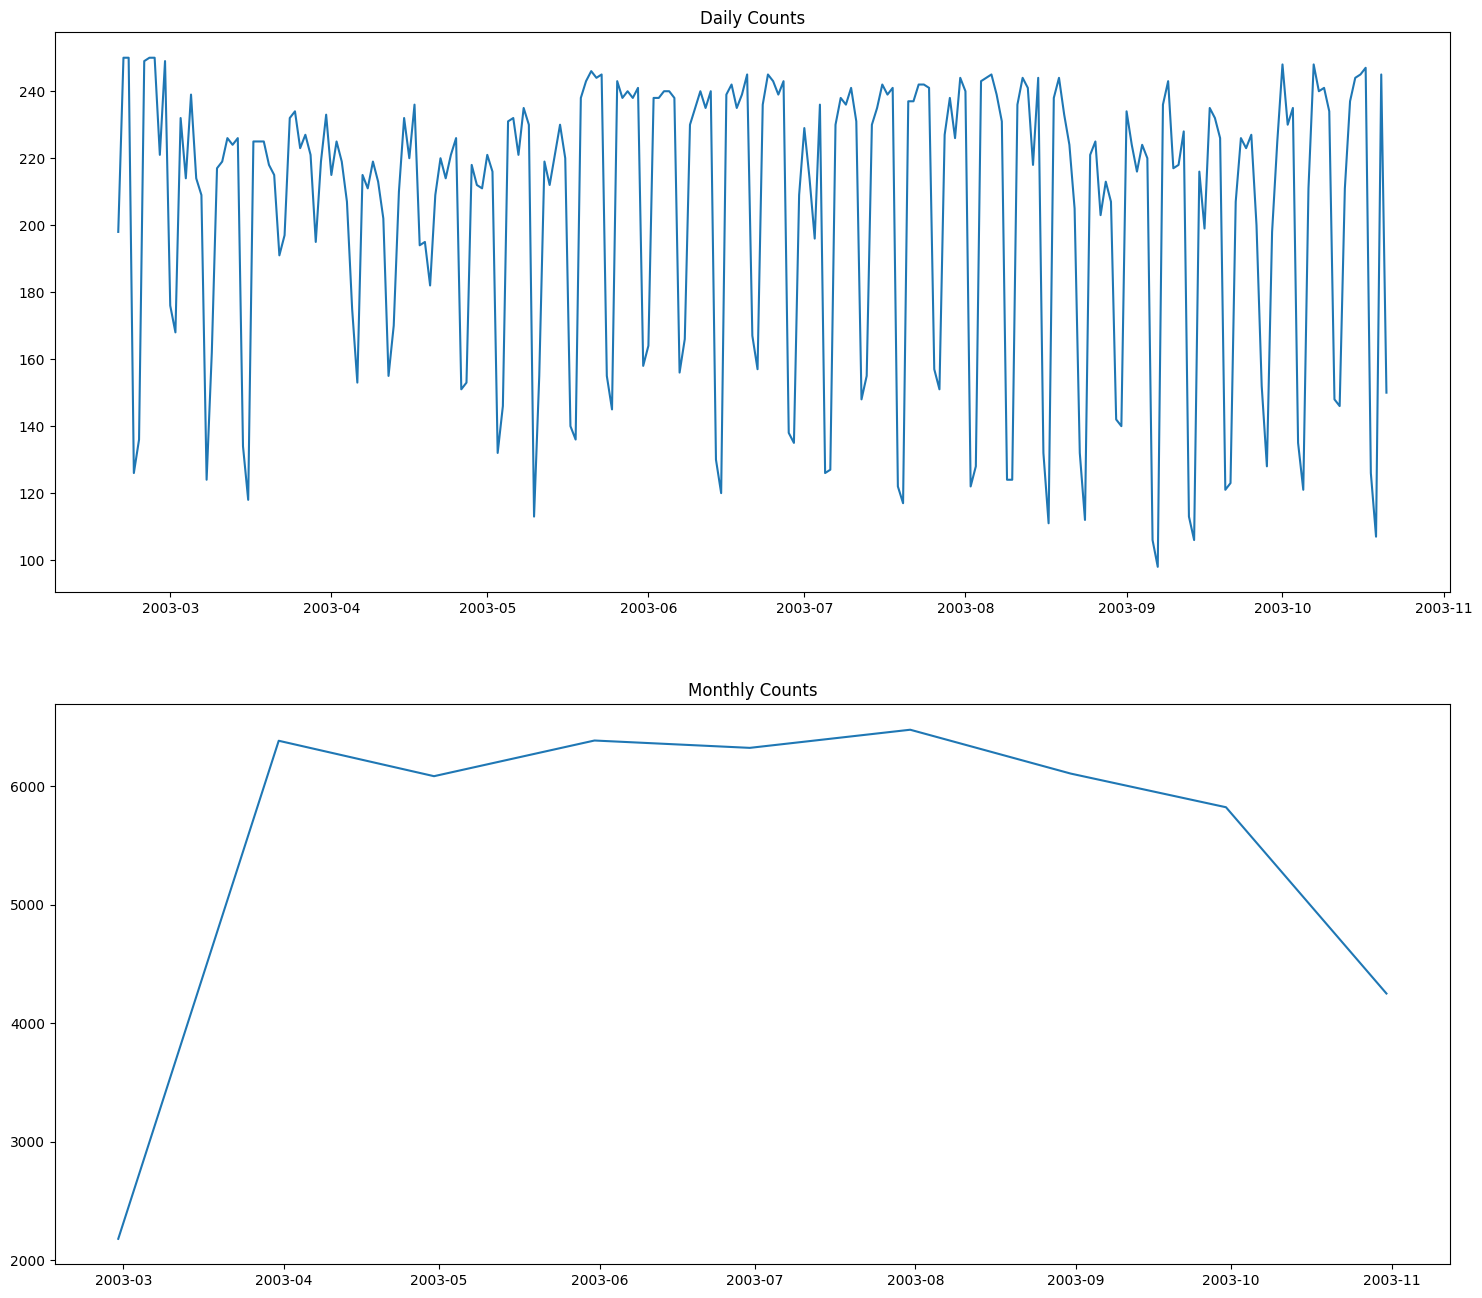

In [29]:
monthly_counts = reindexed_data.resample('M').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(2, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
plt.show()

# Topic Modelling

## Preprocessing

In [30]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: report finds longer hours fewer holidays
Headline after vectorization: 
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 10338)>
  Coords	Values
  (0, 3576)	1
  (0, 7626)	1
  (0, 5494)	1
  (0, 3623)	1
  (0, 4538)	1
  (0, 4465)	1


In [94]:
n_topics = 10

## Latent Semantic Analysis

In [95]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [96]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [97]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [98]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [99]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    topic_sum = sum(1 for x in lsa_keys if x == i)
    print(f"Topic {i+1} (Total documents: {topic_sum}): {top_n_words_lsa[i]}")

Topic 1 (Total documents: 1655): police probe crash death missing wa hospital woman dead sydney
Topic 2 (Total documents: 1604): govt urged qld nsw vic report tas plans drought sa
Topic 3 (Total documents: 592): new set hits year open president laws service home sets
Topic 4 (Total documents: 661): man face charged charges dies charge murder faces court guilty
Topic 5 (Total documents: 1427): council water security rise return coast support restrictions funds group
Topic 6 (Total documents: 1188): iraq war killed pm iraqi bush troops baghdad anti calls
Topic 7 (Total documents: 1675): world cup win wins australia south lead england final tour
Topic 8 (Total documents: 448): plan health boost concerns water group public indigenous doctors power
Topic 9 (Total documents: 336): says korea ban talks nuclear downer sars north real health
Topic 10 (Total documents: 414): court appeal high claims told case hears family inquiry ruling


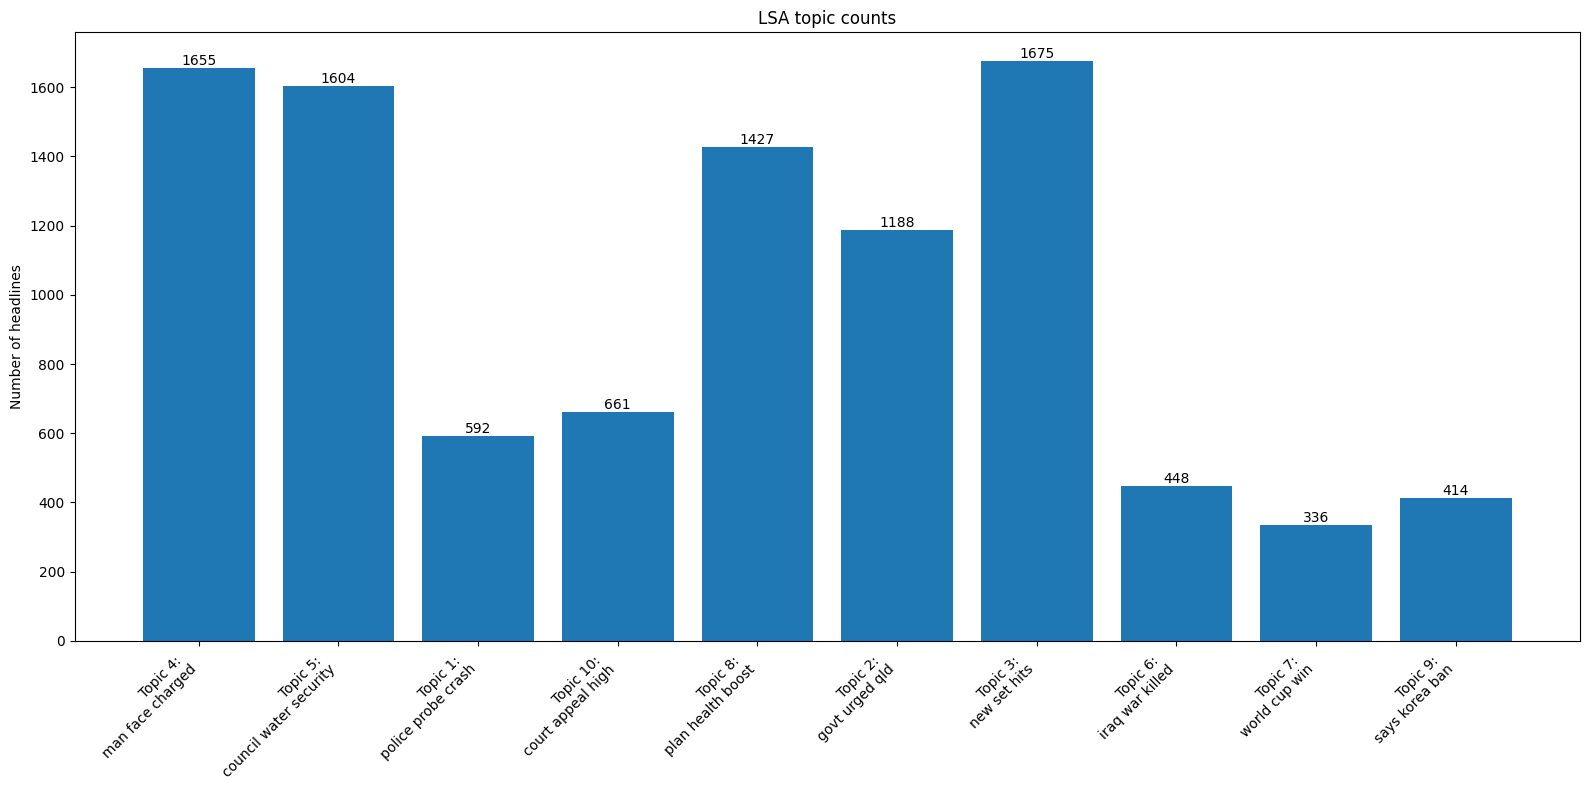

In [100]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_categories_adjusted = [i+1 for i in lsa_categories] 
labels = ['Topic {}: \n'.format(i+1) + top_3_words[i] for i in range(len(top_3_words))]

fig, ax = plt.subplots(figsize=(16,8))
bars = ax.bar(lsa_categories, lsa_counts);

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', 
            ha='center', va='bottom')
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.tight_layout() 
plt.show()

In [101]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 2.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.003384
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.662804
[t-SNE] KL divergence after 2000 iterations: 1.260986


In [102]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [103]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [104]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)


In [105]:
def calculate_npmi(word1_idx, word2_idx, document_term_matrix, epsilon=1e-12):
    """
    Calculate NPMI (Normalized Pointwise Mutual Information) between two words
    Range: [-1, 1], where 1 indicates perfect association
    """
    # Get word occurrence vectors
    word1_doc = document_term_matrix[:, word1_idx].toarray().flatten()
    word2_doc = document_term_matrix[:, word2_idx].toarray().flatten()
    
    # Calculate joint and marginal probabilities
    n_docs = document_term_matrix.shape[0]
    
    p_x = (word1_doc > 0).sum() / n_docs
    p_y = (word2_doc > 0).sum() / n_docs
    p_xy = np.logical_and(word1_doc > 0, word2_doc > 0).sum() / n_docs
    
    # Calculate NPMI
    if p_xy < epsilon or p_x < epsilon or p_y < epsilon:
        return 0.0
    
    pmi = np.log(p_xy / (p_x * p_y))
    npmi = pmi / (-np.log(p_xy))

    if np.isnan(npmi) or np.isinf(npmi):
        return 0.0
    
    return npmi

def calculate_topic_coherence_npmi(topic_words, document_term_matrix, count_vectorizer):
    """
    Calculate Topic Coherence using NPMI
    Range: [-1, 1], where 1 indicates perfect coherence
    """
    vocabulary = count_vectorizer.get_feature_names_out()
    words = topic_words.split()
    
    # Get word indices
    word_indices = []
    for word in words:
        try:
            idx = np.where(vocabulary == word)[0][0]
            word_indices.append(idx)
        except IndexError:
            print(f"Warning: Word '{word}' not found in vocabulary")
            continue
    
    if len(word_indices) < 2:
        print(f"Warning: Not enough valid words found in topic")
        return 0.0
    
    # Calculate NPMI for all word pairs
    npmi_scores = []
    for i in range(len(word_indices)):
        for j in range(i+1, len(word_indices)):
            score = calculate_npmi(word_indices[i], word_indices[j], document_term_matrix)
            if not np.isnan(score):  # Skip NaN values
                npmi_scores.append(score)
    
    # Return average NPMI
    if not npmi_scores:
        return 0.0
    return np.mean(npmi_scores)

def calculate_topic_diversity(topic_words_list):
    """
    Calculate Topic Diversity: percentage of unique words across all topics
    Range: [0, 1], where 0 indicates redundant topics and 1 indicates varied topics
    """
    # Get all words
    all_words = []
    for topic_words in topic_words_list:
        all_words.extend(topic_words.split())
    
    # Calculate proportion of unique words
    unique_words = len(set(all_words))
    total_words = len(all_words)
    
    return unique_words / total_words

In [106]:
# Calculate TC and TD
lsa_coherence_scores = []
for topic_words in top_n_words_lsa:
    score = calculate_topic_coherence_npmi(topic_words, small_document_term_matrix, 
                                         small_count_vectorizer)
    lsa_coherence_scores.append(score)

average_coherence = np.mean(lsa_coherence_scores)
diversity_score = calculate_topic_diversity(top_n_words_lsa)

# Print results
print("\nLSA Results:")
print(f"Topic Coherence: {average_coherence:.4f}")
print(f"Topic Diversity: {diversity_score:.4f}")


LSA Results:
Topic Coherence: 0.1173
Topic Diversity: 0.9600


## Latent Dirichilet Allocation



In [107]:

lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [108]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [109]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)
for i in range(len(top_n_words_lda)):
    topic_sum = sum(1 for x in lda_keys if x == i)
    print(f"Topic {i+1} (Total documents: {topic_sum}): {top_n_words_lda[i]}")

Topic 1 (Total documents: 1011): man face pm death urged charged govt act public car
Topic 2 (Total documents: 996): court claims war anti support national group day labor concerns
Topic 3 (Total documents: 980): plan korea talks wins north funds nt appeal says push
Topic 4 (Total documents: 1004): iraq set record security dead mp bush war injured warns
Topic 5 (Total documents: 972): council cup world win open rain test south new title
Topic 6 (Total documents: 989): govt sars vic tour boost defends home china bali tourism
Topic 7 (Total documents: 1073): police new govt nsw minister pay lead takes plan iraqi
Topic 8 (Total documents: 964): says killed water australia baghdad england lions restrictions govt report
Topic 9 (Total documents: 1011): crash hospital police dies report funding strike tas workers staff
Topic 10 (Total documents: 1000): man wa qld drought plans inquiry trial consider health farmers


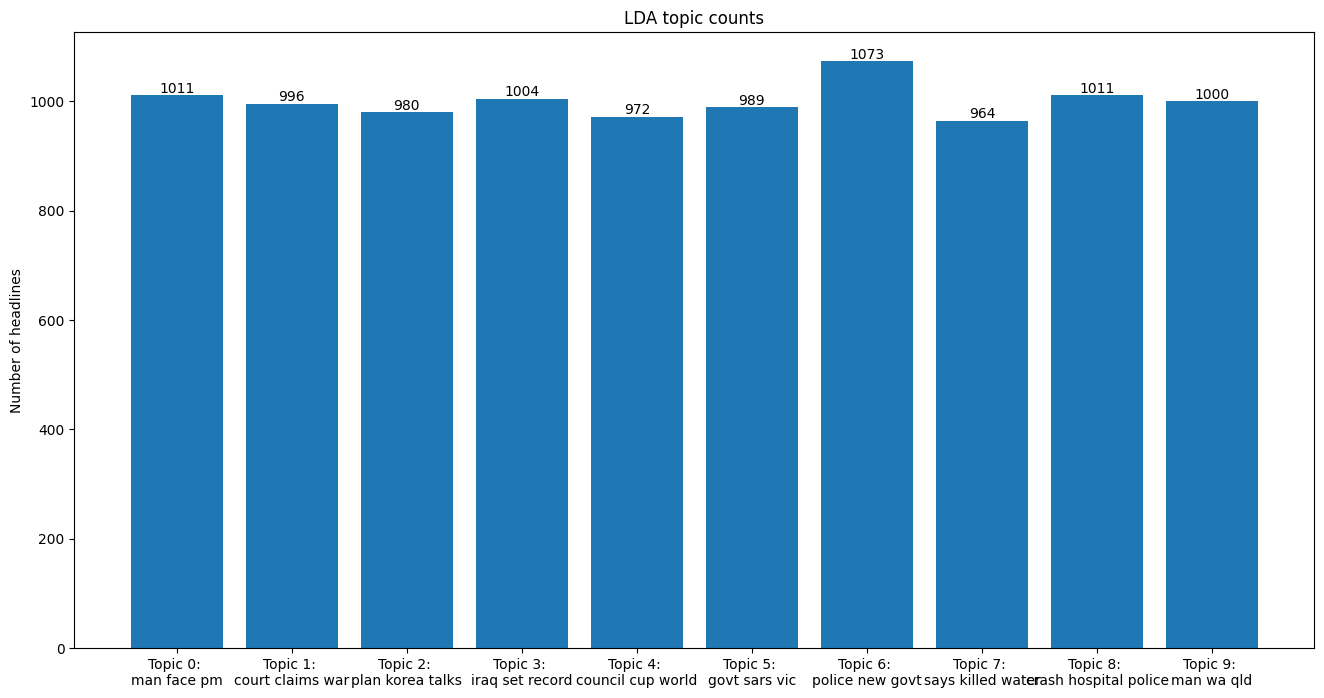

In [110]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
bars = ax.bar(lda_categories, lda_counts);

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',  
            ha='center', va='bottom')
    
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [111]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 2.452s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.081282
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.791374
[t-SNE] KL divergence after 2000 iterations: 1.571729


In [112]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)


In [120]:
# Calculate TC and TD
lda_coherence_scores = []
for topic_words in top_n_words_lda:
    score = calculate_topic_coherence_npmi(topic_words, small_document_term_matrix, 
                                         small_count_vectorizer)
    lda_coherence_scores.append(score)

average_coherence = np.mean(lda_coherence_scores)
diversity_score = calculate_topic_diversity(top_n_words_lda)

# Print results
print("\nLDA Results:")
print(f"Topic Coherence: {average_coherence:.4f}")
print(f"Topic Diversity: {diversity_score:.4f}")


LDA Results:
Topic Coherence: 0.0622
Topic Diversity: 0.9000
